In [1]:
from keras.applications.vgg16 import VGG16##this VGG16 is used in real_world prediction
##from keras.applications import VGG16##Though, this is used for fine-tuned model as the pretrained model

model=VGG16(weights="imagenet")
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

# Load img, turn it into the vgg16's input format

(1, 224, 224, 3)

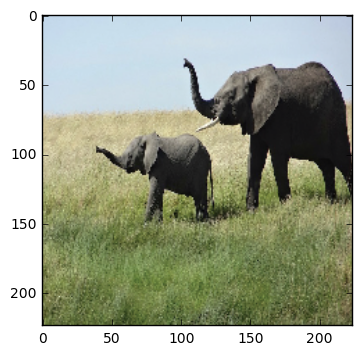

In [40]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input,decode_predictions
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
img_path="elephant.png"

img=image.load_img(img_path,target_size=(224,224))
plt.imshow(img)
x=image.img_to_array(img)
#plt.imshow(x,cmap="viridis")
#turn into [1,224,224,3]
x=np.expand_dims(x,axis=0)
#channel-wise normalization
x=preprocess_input(x)
x.shape

In [41]:
preds=model.predict(x)
print ("Shape:"+str(preds.shape)+". Label:"+str(np.argmax(preds)))
print ("Predicted:"+str(decode_predictions(preds,top=3)[0]))

Shape:(1, 1000). Label:386
Predicted:[('n02504458', 'African_elephant', 0.92076737), ('n01871265', 'tusker', 0.07322716), ('n02504013', 'Indian_elephant', 0.0059608449)]


# Grad-CAM algorithm

(?, 14, 14, 512)
(512,)


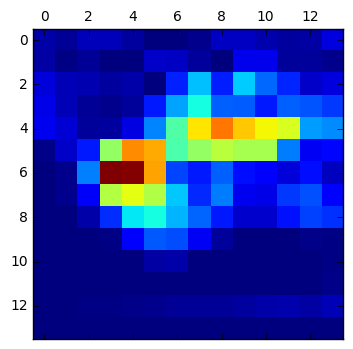

In [43]:
import keras.backend as K
elephant_output=model.output[:,np.argmax(preds)]

last_conv_layer=model.get_layer("block5_conv3")
print(last_conv_layer.output.shape)
grads=K.gradients(elephant_output,last_conv_layer.output)[0]
pooled_grads=K.mean(grads,axis=(0,1,2))
print(pooled_grads.shape)
iterate=K.function([model.input],[pooled_grads,last_conv_layer.output[0]])

pooled_grads_value,conv_layer_value=iterate([x])

for i in range(512):
    conv_layer_value[:,:,i]*=pooled_grads_value[i]
heatmap=np.mean(conv_layer_value,axis=-1)
heatmap=np.maximum(heatmap,0)
heatmap/=np.max(heatmap)
plt.matshow(heatmap)

# Impose heatmap with the orginal image

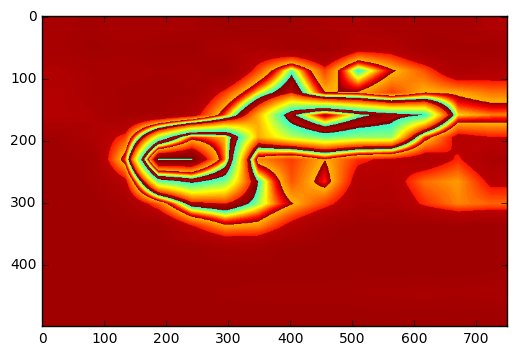

In [46]:
import cv2

img=cv2.imread(img_path)

heatmap=cv2.resize(heatmap,(img.shape[1],img.shape[0]))
heatmap=np.uint8(255*heatmap)
heatmap=cv2.applyColorMap(heatmap,cv2.COLORMAP_JET)

plt.imshow(heatmap)

True

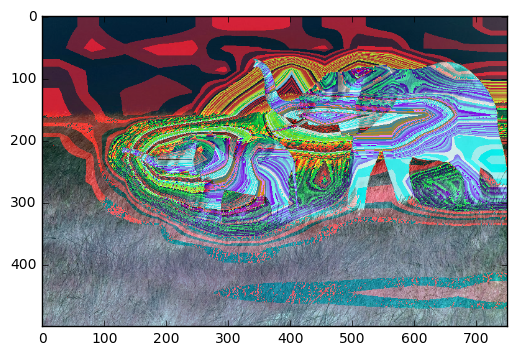

In [48]:
imposed_img=heatmap*0.4+img
plt.imshow(imposed_img)
cv2.imwrite("elephant_cam.png",imposed_img)